In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn
% matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
data_path = './../../data/processed/'

df = pd.read_csv('./../../data/processed/ID_Y.csv')
df = df.loc[df.IMPORT == 0]
empirical = df.groupby(['YEAR']).agg({'ID': 'count', 'VART': 'sum'}) # count == nunique

# *think that mu, sigma are for pooled data, but they could be different in each year.

In [3]:
sales_ID = df.groupby(['ID'])['VART'].sum().sort_values()
Q = 10
q = pd.cut(np.cumsum(sales_ID)/sales_ID.sum(), Q)
q.value_counts() # Hay 12x menos que en el paper porque son ID, no ID, YEAR


(-0.001, 0.1]    416214
(0.1, 0.2]         5156
(0.2, 0.3]         1677
(0.3, 0.4]          730
(0.4, 0.5]          361
(0.5, 0.6]          190
(0.6, 0.7]          102
(0.7, 0.8]           51
(0.8, 0.9]           18
(0.9, 1.0]            6
Name: VART, dtype: int64

In [4]:
df_q = df.merge(q.reset_index(), on = 'ID')

y = df_q.groupby(['VART_y', 'YEAR'])['VART_x'].sum().reset_index()
y.columns = ['q', 'YEAR', 'y']

## Ya tenemos los valores Y

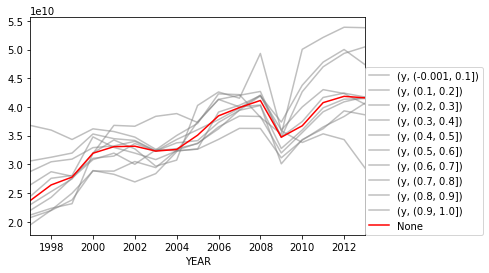

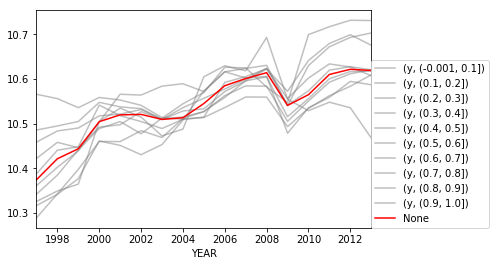

In [5]:
# Lineal
y.set_index(['YEAR', 'q']).unstack().plot(c = '.5', alpha = .5)
y.set_index(['YEAR', 'q']).unstack().median(1).plot(c = 'r')
plt.legend(loc = (1, 0))
plt.show()

# Logs
np.log10(y.set_index(['YEAR', 'q']).unstack()).plot(c = '.5', alpha = .5)
np.log10(y.set_index(['YEAR', 'q']).unstack()).median(1).plot(c = 'r')
plt.legend(loc = (1, 0))
plt.show()

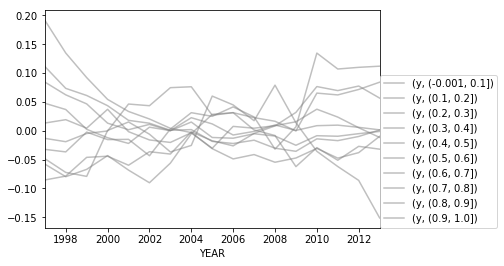

In [6]:
# Logs (y - median)
(np.log10(y.set_index(['YEAR', 'q']).unstack()).T - np.log10(y.set_index(['YEAR', 'q']).unstack()).median(1)).T.plot(c = '.5', alpha = .5)
plt.legend(loc = (1, 0))
plt.show()



In [7]:
Y = y.groupby('YEAR').sum()
logY = np.log10(Y)


In [8]:
x_ = logY.index
y_ = logY['y'].values
p = np.poly1d(np.polyfit(x_, y_, 1))
p

poly1d([ 1.30268034e-02, -1.45770647e+01])

In [9]:
## By definition, the mean value is THE SAME for both the line fit and the actual data.
np.mean(p(x_)) - np.mean(y_)

-7.105427357601002e-15

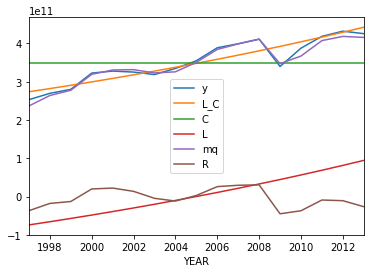

In [10]:
Y['L_C'] = np.power(10, p(x_))
Y['C'] = np.power(10, np.mean(p(x_))) # == np.mean(y_)
Y['L'] = Y['L_C'] - Y['C']
Y['mq'] = Q*y.set_index(['YEAR', 'q']).unstack().median(1) # Quantile medians
# Y['R'] = Y['y'] - Y['L_C']
Y['R'] = Y['mq'] - Y['L_C']

Y.plot()

In [11]:
## Coefficient Matrix
X = Y[['C', 'L', 'R']]
# X

In [12]:
data = y.set_index(['YEAR', 'q']).unstack()

# En este paso ajusto con un OLS simple por ahora, pero en realidad deberia tener un modelo lineal generalizado que incorpore el hecho que hacia el final de la seria todo esta escalado.
# Tiene que ir como la expectativa de Y, que es L + C

# Agarramos alguna de las series del q y lo ajustamos con las 3 componentes L, C, R.

In [13]:
a = X.values # MxN. M would be the time length, N would be how many variables.
b = data.values # MxK. OLS is computed for each of the k columns of b

In [14]:
x, residuals, rank, s = np.linalg.lstsq(a, b, rcond=None)

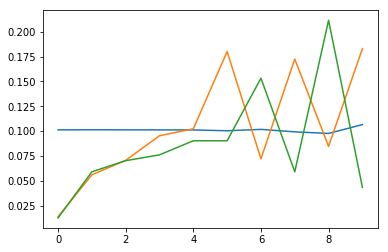

In [15]:
# plt.matshow(x)
plt.plot(x.T)

### Conclusion, restar (L + R) a yq (su porcion de deriva exponencial y shock agregado)

In [16]:
data_Cr = (data.T - (Y/Q)['L'] - (Y/Q)['R']).T
data_r = (data.T - (Y/Q)['L'] - (Y/Q)['R'] - (Y/Q)['C']).T
data_Rr = (data.T - (Y/Q)['L'] - (Y/Q)['C']).T


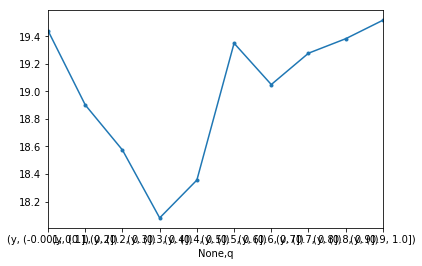

In [17]:
np.log10(data_Cr.var()).plot(marker = '.')

In [18]:
np.log10(data_Cr).corr().median().sort_values()

   q            
y  (0.8, 0.9]      -0.230318
   (0.9, 1.0]      -0.219039
   (0.7, 0.8]      -0.203645
   (0.5, 0.6]      -0.146708
   (0.6, 0.7]      -0.015866
   (0.4, 0.5]       0.036384
   (0.3, 0.4]       0.036762
   (0.2, 0.3]       0.077666
   (-0.001, 0.1]    0.081888
   (0.1, 0.2]       0.090306
dtype: float64

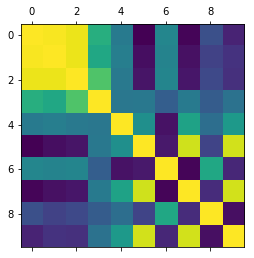

In [19]:
plt.matshow(data_Cr.corr())

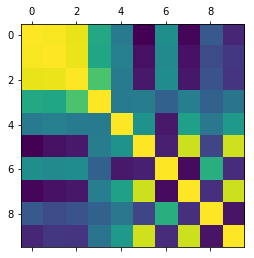

In [20]:
plt.matshow(np.log10(data_Cr).corr())

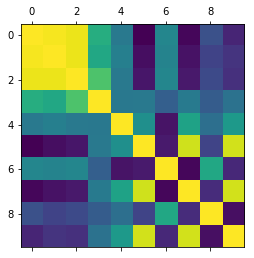

In [21]:
# np.round(data_r.corr(), 2)
plt.matshow(np.round(data_r.corr(), 2))

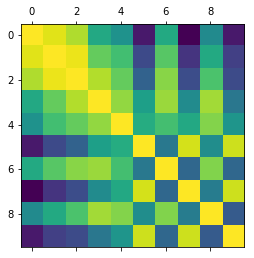

In [22]:
plt.matshow(np.round(data_Rr.corr(), 2))

In [23]:
import scipy.linalg as la
C = data_Rr.corr()
# C = data_r.corr()
# C = np.log10(data_Cr)
# C = data_Cr.corr()#/8e18

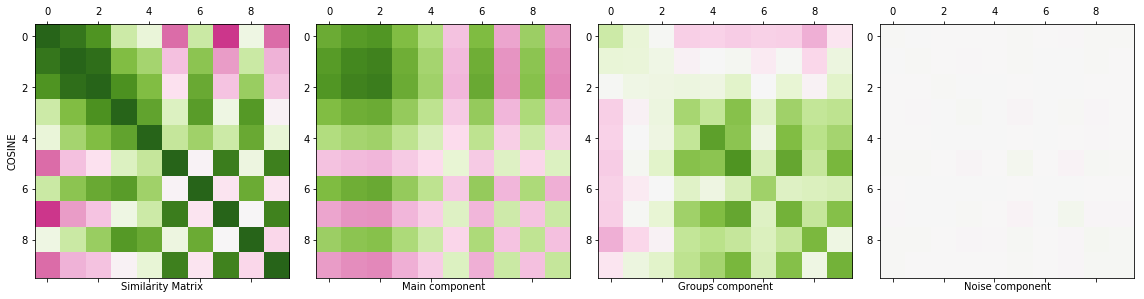

In [24]:
fig, axs = plt.subplots(1, 4, figsize = (16, 4))
cm = 'PiYG'
n_corte = 5 # ~20

avals, avecs = la.eig(C.values)
avals = np.real(avals) # == np.abs(avals)
def component(k, avals = avals, avecs = avecs):
    uk = np.array(len(avals)*[avecs.T[k]]).reshape(avecs.shape) # la componente k agarra el elemento k de todos los autovectores.
    return np.real(avals[k]*np.multiply(uk.T, uk))

C_s = component(0) # structural component
C_g = np.array([component(i) for i in range(1, n_corte)]).sum(axis=0) # random component
C_r = np.array([component(i) for i in range(n_corte, len(avals))]).sum(axis=0) # random component

axs[0].matshow(C, vmin = -1, vmax = 1, cmap = cm); axs[0].set_xlabel('Similarity Matrix')
axs[0].set_ylabel('COSINE')
axs[1].matshow(C_s, vmin = -1, vmax = 1, cmap = cm); axs[1].set_xlabel('Main component')
axs[2].matshow(C_g, vmin = -1, vmax = 1, cmap = cm); axs[2].set_xlabel('Groups component')
axs[3].matshow(C_r, vmin = -1, vmax = 1, cmap = cm); axs[3].set_xlabel('Noise component')

plt.tight_layout()
plt.show()

## Veamos la combinacion de las varianzas.

In [25]:
# Por como descompusimos la serie del total:
# Y['y'] = Y['C'] + Y['L'] + Y['R'] + data_r.sum(1)
Y['y'].var()/1e20

31.33103239847797

In [26]:
concat = pd.concat([Y['C'], Y['L'], Y['R'], data_r['y']], axis = 1)

In [27]:
# La identidad esta. Habria que ver como son las componentes.
# Y['y'].var() == cov.sum().sum()

cov = concat.cov()

cov.columns = list(cov.columns[:-Q]) + Q*['qs']
cov.index = list(cov.index[:-Q]) + Q*['qs']

grouped_cov = cov.unstack().groupby(level = (0, 1)).sum().unstack()

In [28]:
grouped_cov/1e20

,C,L,R,qs
C,0.0,0.000000,0.000000,0.000000
L,0.0,28.277661,-2.048480,1.128565
R,0.0,-2.048480,5.999617,-0.869011
qs,0.0,1.128565,-0.869011,0.631605


In [29]:
data_r['y'].var().sum()/1e20

1.5211579649421854

In [30]:
(data_r['y'].cov().sum().sum() - data_r['y'].var().sum())/1e20

-0.8895524656001154

In [31]:
## Now, do the same but without the line and constant terms already out.

# Y['Y - C_L'] = Y['R'] + data_r.sum(1)

concat = pd.concat([Y['R'], data_r['y']], axis = 1)
cov = concat.cov()

cov.columns = list(cov.columns[:-Q]) + Q*['qs']
cov.index = list(cov.index[:-Q]) + Q*['qs']

grouped_cov = cov.unstack().groupby(level = (0, 1)).sum().unstack()

In [32]:
(Y['y'] - Y['L_C']).var()/1e20

4.8932005007718375

In [33]:
grouped_cov/1e20


,R,qs
R,5.999617,-0.869011
qs,-0.869011,0.631605


In [34]:
np.diag(data_r['y'].cov().values)

array([2.75285519e+19, 7.96695425e+18, 3.75010947e+18, 1.20581707e+18,
       2.26928573e+18, 2.23554072e+19, 1.12044362e+19, 1.89188319e+19,
       2.40954967e+19, 3.28209061e+19])

In [35]:

# ld = data_Rr.cov().where(~np.triu(np.ones(data_Cr.cov().shape)).astype(np.bool))
# 2*ld.sum().sum()

In [36]:
# Sum of Cov matrix is really near zero. # Not zero, probably because of nuemrical imprecision. 

# It means that the off diagonal elements conteract directly the sum of all variances.

In [37]:
# points['var_diff_agg_i'] = np.log10(value_sum).diff(axis = 1).var(1)

In [38]:
# Creo una tabla de 
Q = 10
T = 17

# var_r = 0.004**2 ### se mueve s.std(1) +-1
var_r = 0.04**2 ### se mueve s.std(1) +-10 en cada q
# np.log10(110)-2

r = np.random.normal(0, np.sqrt(var_r), T) # Es normal. Hay que agregarsela a los logs, no a lo lineal, pero si esta cerca del 1% es logs y lineal se aproxima. Para eso, sumamos al logaritmo un error y pedimos que sea de cerca de 1%.

t0 = pd.DataFrame(2*np.ones((Q, T))) # Una matrix de 100's -> 10Q suman 1000, logs son 2 y 3, copado.
# Asi va a estar bien planteada en logs, pero no se si va a dar bien su suma. Para eso querriamos que la distribucion fuera normal en lineal. Casi se cumple, pero da error numerico.,
# Igual quizas este queda muy debajo de error de probabilidad, igual...


# # Apply general shock

tr = t0 + r
# tr - t0 = pd.concat(Q*[pd.Series(r)], axis = 1).T

tq = t0.copy()
tq.loc[0] = tq.loc[0] + r
# tq.loc[1] = tq.loc[1] - r/2

tqr = tr.copy()
# tqr.loc[0] = tqr.loc[0] + r
tqr.loc[0] = tqr.loc[0] - r/2

s0 = np.power(10, t0)
sr = np.power(10, tr)
sq = np.power(10, tq)


In [39]:
np.round(tq.T.cov()/r.var(), 2)

,0,1,2,3,4,5,6,7,8,9
0,1.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# # Creo una tabla de 
# Q = 10
# T = 2700

# var_r = 10
# r = np.random.normal(0, np.sqrt(var_r), T)


# s = pd.DataFrame(np.power(10, np.log10(100*np.ones((10, T)))))
# # # Apply general shock
# # s = s + r
# # Apply shock on first row
# s.loc[0] = s.loc[0] + r
# t = np.log10(s)

In [41]:
# np.log10(s).var(1)   # variance of the log levels ## cambie t por s

In [42]:
# s.var(1) # Variance in linear levels ## cambie t por s

In [43]:
# np.log10(s).var(1)/np.log10(s.sum()).var() # Q**2   ### Ratio between variance in the log level of quantile to variance of log level of total
## cambie t por s

In [44]:
# La suma de las covarianzas es el sigma cuadrado que tiene la suma.
# Aca asumimos que habia un shock uniforme para todos, que seria como una constante en la matriz de covarianza.
# Tanto en lineal como en logs la cuenta da EXACTA

# sr.sum().var() = sr.T.cov().sum().sum()

# tr.sum().var() = tr.T.cov().sum().sum()

In [45]:
var_r

0.0016

In [46]:
# sq.T.cov()

cov_coef_sum_ = 1

In [47]:
# tq.T.cov()/r.var()

In [48]:
sr.sum().var()

6788.434790428615

In [49]:
sr.T.cov().sum().sum()

6788.434790428618

In [50]:
tr.sum().var()/(Q**2*r.var())

1.0625000000000022

In [51]:
tr.iloc[0].var()/r.var()

1.0624999999999987

In [52]:
tr.T.cov().sum().sum()/(Q**2*r.var())

1.062499999999999

In [53]:
Q**2*sq.sum().var()/cov_coef_sum_

6788.434790428609

In [54]:
Q**2*sq.T.cov().sum().sum()/cov_coef_sum_

6788.434790428617

In [55]:
tq.sum().var()/(cov_coef_sum_*r.var())

1.0625000000000149

In [56]:
tq.T.cov().sum().sum()/(cov_coef_sum_*r.var())

1.0624999999999987

In [57]:
# Yo estaba con:
np.log10(sr.sum()).var()/r.var()  # En este caso si me da esta identidad.

1.0624999999999962

In [58]:
(T)/(T-1)

1.0625

In [59]:
rat = np.power(10, 2)/np.power(10, 3)
rat = 1/Q

np.log(10)/2 * rat * (1 - rat) * r.var()

0.00012515016576955534

In [60]:
np.log10(sq.sum()).var()*Q**2/(cov_coef_sum_*r.var())

1.059148465671407

In [61]:
# np.log10(sq.sum())

In [62]:
 ## Aproximadamente cerca de Q**2/cov_coef_sum_ pero no completamente
print(Q**2/cov_coef_sum_)
np.log10(sr.sum()).var()/np.log10(sq.sum()).var()

100.0


100.31643668826585

In [63]:
# Dejo de expresar en terminos de var_r y paso a 

# np.log10(sq.sum()).var() ~ cov_coef_sum_/Q**2 * var_r

In [64]:
# np.log10(data).cov()

In [65]:
np.log10(data).cov().sum().sum()/Q**2

0.00517681064938852

In [66]:
np.log10(data.sum(1)).var()

0.0050679984429212845

In [67]:
np.log10(sr.sum()).var()

0.0012833117345151576

In [68]:
np.log10(sr.iloc[0]).var()

0.0012833117345151606

In [69]:
np.log10(data.sum(1))

YEAR
1997    11.403394
1998    11.430871
1999    11.447405
2000    11.508733
2001    11.515672
2002    11.512228
2003    11.503503
2004    11.524696
2005    11.550103
2006    11.589713
2007    11.601354
2008    11.614233
2009    11.531341
2010    11.588565
2011    11.621870
2012    11.635697
2013    11.629118
dtype: float64

In [70]:
## Los terminos fuera de la diagonal tienen alta covarianza porque se desvian mucho.

In [71]:
np.log10(data).cov().sum().sum() 

0.517681064938852

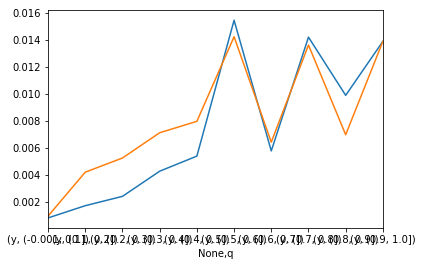

In [72]:
np.log10(data).var().plot()
np.log10(data).cov().iloc[9].plot()

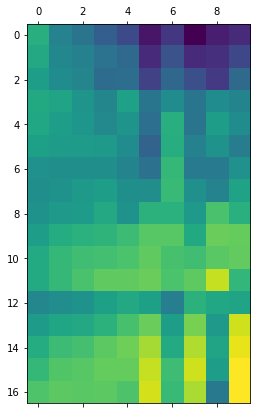

In [73]:
plt.matshow(np.log10(data))